In [1]:
# Setup -------------------------------------------------------------------

# Cleans workspace and loads package
rm(list = ls())

## You should create a folder called "packages" first
lib <-  "../packages/"

## now change the libPaths to include the default + the folder
current.lib <- .libPaths()
.libPaths(c(lib, current.lib))

## checks if it works
.libPaths()

[1] "/u/project/sriram/ukbiobank/data/mr_ukb_split/packages"  
[2] "/u/home/n/nlapier2/R/x86_64-pc-linux-gnu-library/3.6"    
[3] "/u/local/apps/R/3.6.1/gcc-4.9.3_MKL-2018/lib64/R/library"

In [2]:
library(sensemakr)
library(ivmodel)
library(AER)
library(dplyr)
library(data.table)
library(stargazer)
library(speedglm)
options(digits = 4, scipen = 99)

See details in:

Carlos Cinelli and Chad Hazlett (2020). Making Sense of Sensitivity: Extending Omitted Variable Bias. Journal of the Royal Statistical Society, Series B (Statistical Methodology).

Loading required package: car

Loading required package: carData

Loading required package: lmtest

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich

Loading required package: survival


Attaching package: ‘dplyr’


The following object is masked from ‘package:car’:

    recode


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last



Please cite as: 


 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistic

In [3]:
# reads processed and filtered data
data <- readRDS("../processed_data/filter4_data.rds")

In [4]:
# standardize PRS
data[ ,prs_std  := as.numeric(scale(prs))]
data[ ,bmi_std  := as.numeric(scale(bmi))]
data[ ,town_std:= as.numeric(scale(townsend))]
data[ ,sbp_std:= as.numeric(scale(sbp))]
data[ ,dbp_std:= as.numeric(scale(dbp))]

In [ ]:
dim(data)

In [6]:
data <- na.omit(data, cols = c("sbp", "dbp",
                                "t2d",
                                "townsend",
                                "prs",
                                "bmi_std",
                                "age",
                                "sex",
                                "alcohol",
                                "smoking",
                                "assessment_centre",
                                "genotype_batch",
                                "PC1", "PC2", "PC3", "PC4", "PC5", "PC6",
                                "PC7", "PC8", "PC9", "PC10", "PC11",
                                "PC12", "PC13", "PC14", "PC15", "PC16", "PC17",
                                "PC18", "PC19", "PC20"))

In [7]:
X <- model.matrix(~age + I(age^2) + sex +
                         alcohol + smoking +
                         assessment_centre + genotype_batch +
                         PC1 + PC2 + PC3 +  PC4 + PC5 + PC6 +
                         PC7 + PC8 + PC9 + PC10 + PC11 +
                         PC12 + PC13 + PC14 + PC15 + PC16 + PC17 +
                         PC18 + PC19 + PC20, data= data)

In [16]:
ivmodel.dbp <- ivmodel(Y = data$dbp_std, D = data$bmi_std, Z = data$prs_std, X = X)

In [17]:
summary(ivmodel.dbp)
confint(ivmodel.dbp)


Call:
ivmodel(Y = data$dbp_std, D = data$bmi_std, Z = data$prs_std, 
    X = X)
sample size: 270307
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

First Stage Regression Result:

F=4605, df1=1, df2=270147, p-value is <0.0000000000000002
R-squared=0.01676,   Adjusted R-squared=0.01676
Residual standard error: 0.9603 on 270148 degrees of freedom
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

Coefficients of k-Class Estimators:

             k Estimate Std. Error t value            Pr(>|t|)    
OLS    0.00000  0.27810    0.00187  149.04 <0.0000000000000002 ***
Fuller 1.00000  0.14493    0.01455    9.96 <0.0000000000000002 ***
TSLS   1.00000  0.14490    0.01455    9.96 <0.0000000000000002 ***
LIML   1.00000  0.14490    0.01455    9.96 <0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

Alternative tests for the treatment effect under H_0: beta=0.

Anderson-Rub

,2.5%,97.5%
OLS,0.2744,0.2818
Fuller,0.1164,0.1734
TSLS,0.1164,0.1734
LIML,0.1164,0.1734
AR,0.1163,0.1733
CLR,0.1163,0.1733


In [18]:
# First Stage
first.stage <- lm(bmi_std ~ prs_std + age + I(age^2) + sex +
                         alcohol + smoking  +
                         assessment_centre + genotype_batch +
                         PC1 + PC2 + PC3 +  PC4 + PC5 + PC6 +
                         PC7 + PC8 + PC9 + PC10 + PC11 +
                         PC12 + PC13 + PC14 + PC15 + PC16 + PC17 +
                         PC18 + PC19 + PC20,
                         data = data)

In [19]:
# variable groups
assessment_centre <- grep(names(coef(first.stage)), pattern = "assessment_centre", value = T)
batch_effects     <- grep(names(coef(first.stage)), pattern = "genotype_batch", value = T)
PCs               <- grep(names(coef(first.stage)), pattern = "PC", value = T)
smoking           <- grep("smoking",names(coef(first.stage)), value = T)
alcohol           <- grep("alcohol",names(coef(first.stage)), value = T)
age               <- grep("age",names(coef(first.stage)), value = T)
sex               <- grep("sex",names(coef(first.stage)), value = T)
all               <- c(assessment_centre, batch_effects, PCs, smoking, alcohol, age, sex)

In [20]:
# we can use for checking partial association of PRS with other variables
instrument.model <- lm(prs_std ~  age + I(age^2) + sex +
                         alcohol + smoking  +
                         assessment_centre + genotype_batch +
                         PC1 + PC2 + PC3 +  PC4 + PC5 + PC6 +
                         PC7 + PC8 + PC9 + PC10 + PC11 +
                         PC12 + PC13 + PC14 + PC15 + PC16 + PC17 +
                         PC18 + PC19 + PC20,
                         data = data)

In [21]:
sensitivity_stats(model = first.stage,  treatment = "prs_std")

treatment,estimate,se,t_statistic,r2yd.x,rv_q,rv_qa,f2yd.x,dof
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<numeric>,<numeric>,<dbl>,<int>
prs_std,0.1257,0.001852,67.86,0.01676,0.1223,0.119,0.01705,270147


In [22]:
group_partial_r2(model = first.stage, covariates = all)

[1] 0.04932

In [23]:
summary(instrument.model)$r.
group_partial_r2(model = instrument.model, covariates = all)

[1] 0.003983

[1] 0.003983

In [24]:
summary(first.stage)


Call:
lm(formula = bmi_std ~ prs_std + age + I(age^2) + sex + alcohol + 
    smoking + assessment_centre + genotype_batch + PC1 + PC2 + 
    PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + PC11 + PC12 + 
    PC13 + PC14 + PC15 + PC16 + PC17 + PC18 + PC19 + PC20, data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-3.559 -0.650 -0.136  0.496  9.764 

Coefficients:
                                      Estimate  Std. Error t value
(Intercept)                        -2.51275171  0.09519011  -26.40
prs_std                             0.12570229  0.00185231   67.86
age                                 0.06767546  0.00337100   20.08
I(age^2)                           -0.00057199  0.00003039  -18.82
sexMale                             0.21424365  0.00379002   56.53
alcoholNever                        0.35480942  0.00840528   42.21
alcoholOnce or twice a week         0.19905597  0.00545082   36.52
alcoholOne to three times a month   0.33869268  0.00692884   48.88
alcoholPrefer not to

In [25]:
summary(instrument.model)


Call:
lm(formula = prs_std ~ age + I(age^2) + sex + alcohol + smoking + 
    assessment_centre + genotype_batch + PC1 + PC2 + PC3 + PC4 + 
    PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + PC11 + PC12 + PC13 + 
    PC14 + PC15 + PC16 + PC17 + PC18 + PC19 + PC20, data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-4.468 -0.676 -0.004  0.672  5.367 

Coefficients:
                                     Estimate Std. Error t value
(Intercept)                        -0.1828906  0.0988722   -1.85
age                                 0.0047034  0.0035014    1.34
I(age^2)                           -0.0000454  0.0000316   -1.44
sexMale                             0.0169030  0.0039365    4.29
alcoholNever                        0.0815533  0.0087290    9.34
alcoholOnce or twice a week         0.0504234  0.0056609    8.91
alcoholOne to three times a month   0.0680680  0.0071957    9.46
alcoholPrefer not to answer        -0.0186942  0.0739332   -0.25
alcoholSpecial occasions only       0.0833765  0

In [26]:
sens.first.stage.all <- sensemakr(model = first.stage,
                              treatment = "prs_std",
                              benchmark_covariates = list(`All` = all),
                             kd = c(2, 4, 6, 8))

In [27]:
summary(sens.first.stage.all)

Sensitivity Analysis to Unobserved Confounding

Model Formula: bmi_std ~ prs_std + age + I(age^2) + sex + alcohol + smoking + 
    assessment_centre + genotype_batch + PC1 + PC2 + PC3 + PC4 + 
    PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + PC11 + PC12 + PC13 + 
    PC14 + PC15 + PC16 + PC17 + PC18 + PC19 + PC20

Null hypothesis: q = 1 and reduce = TRUE 
-- This means we are considering biases that reduce the absolute value of the current estimate.
-- The null hypothesis deemed problematic is H0:tau = 0 

Unadjusted Estimates of 'prs_std': 
  Coef. estimate: 0.126 
  Standard Error: 0.002 
  t-value (H0:tau = 0): 67.86 

Sensitivity Statistics:
  Partial R2 of treatment with outcome: 0.017 
  Robustness Value, q = 1: 0.122 
  Robustness Value, q = 1, alpha = 0.05: 0.119 

Verbal interpretation of sensitivity statistics:

-- Partial R2 of the treatment with the outcome: an extreme confounder (orthogonal to the covariates) that explains 100% of the residual variance of the outcome, would need t

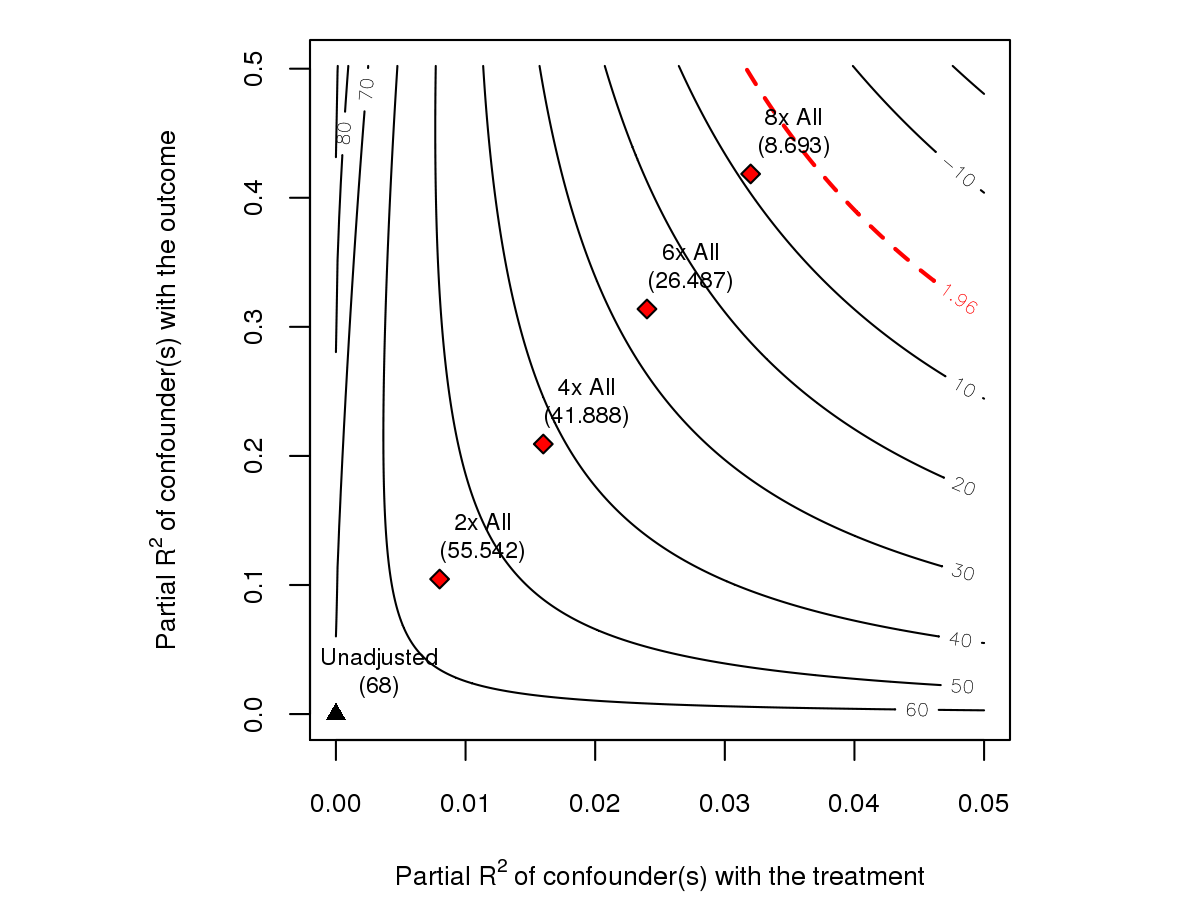

In [28]:
options(repr.plot.width = 6, repr.plot.height = 4.5, repr.plot.res = 200)
plot(sens.first.stage.all, sensitivity.of = "t-value", lim = 0.05)

In [29]:
# RF Diastolic Blood Pressure Sensitivity

reduced.form.dbp <- lm(dbp_std ~ prs_std + age + I(age^2) + sex +
                         alcohol + smoking +
                         assessment_centre + genotype_batch +
                         PC1 + PC2 + PC3 +  PC4 + PC5 + PC6 +
                         PC7 + PC8 + PC9 + PC10 + PC11 +
                         PC12 + PC13 + PC14 + PC15 + PC16 + PC17 +
                         PC18 + PC19 + PC20,
                         data = data)

In [30]:
partial_r2(reduced.form.dbp, covariates = "prs_std")

prs_std 
0.0003454

In [31]:
sensitivity_stats(reduced.form.dbp, treatment = "prs_std")

treatment,estimate,se,t_statistic,r2yd.x,rv_q,rv_qa,f2yd.x,dof
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<numeric>,<numeric>,<dbl>,<int>
prs_std,0.0182,0.001884,9.661,0.0003454,0.01842,0.01471,0.0003455,270147


In [32]:
sense.rf.dbp <- sensemakr(model = reduced.form.dbp,
                              treatment = "prs_std")#,
                              #benchmark_covariates = list(`All` = all),
                              #kd = c(1))

In [33]:
summary(sense.rf.dbp)

Sensitivity Analysis to Unobserved Confounding

Model Formula: dbp_std ~ prs_std + age + I(age^2) + sex + alcohol + smoking + 
    assessment_centre + genotype_batch + PC1 + PC2 + PC3 + PC4 + 
    PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + PC11 + PC12 + PC13 + 
    PC14 + PC15 + PC16 + PC17 + PC18 + PC19 + PC20

Null hypothesis: q = 1 and reduce = TRUE 
-- This means we are considering biases that reduce the absolute value of the current estimate.
-- The null hypothesis deemed problematic is H0:tau = 0 

Unadjusted Estimates of 'prs_std': 
  Coef. estimate: 0.018 
  Standard Error: 0.002 
  t-value (H0:tau = 0): 9.661 

Sensitivity Statistics:
  Partial R2 of treatment with outcome: 0 
  Robustness Value, q = 1: 0.018 
  Robustness Value, q = 1, alpha = 0.05: 0.015 

Verbal interpretation of sensitivity statistics:

-- Partial R2 of the treatment with the outcome: an extreme confounder (orthogonal to the covariates) that explains 100% of the residual variance of the outcome, would need to ex

In [34]:
str(sense.rf.dbp$sensitivity_stats)

'data.frame':	1 obs. of  9 variables:
 $ treatment  : chr "prs_std"
 $ estimate   : num 0.0182
 $ se         : num 0.00188
 $ t_statistic: num 9.66
 $ r2yd.x     : num 0.000345
 $ rv_q       : num 0.0184
  ..- attr(*, "q")= num 1
  ..- attr(*, "alpha")= num 1
 $ rv_qa      : num 0.0147
  ..- attr(*, "q")= num 1
  ..- attr(*, "alpha")= num 0.05
 $ f2yd.x     : num 0.000345
 $ dof        : int 270147


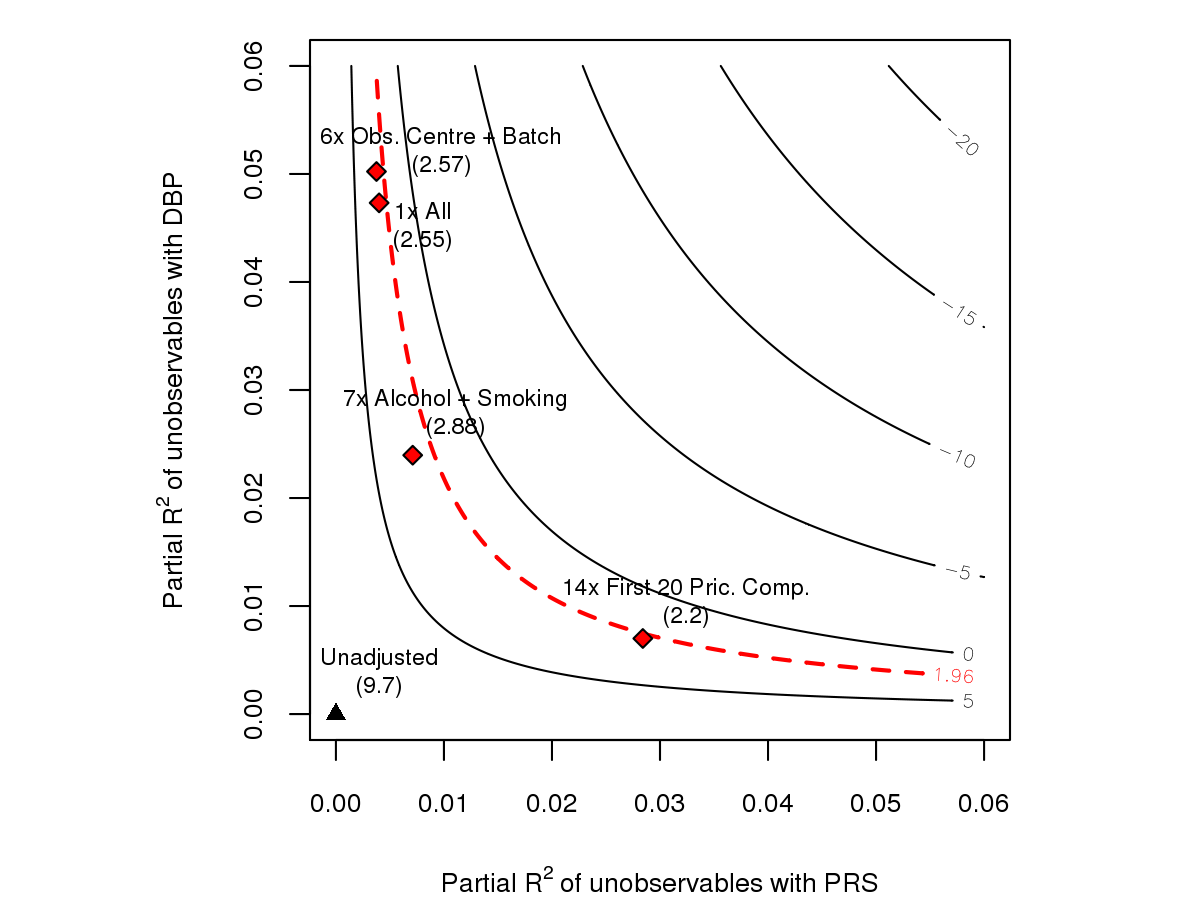

In [41]:
# Contour plot for bounding on Diastolic Blood Pressure (DBP)
xlab <- expression(paste("Partial ", R^2, " of unobservables with PRS"))
ylab <- expression(paste("Partial ", R^2, " of unobservables with DBP"))
options(repr.plot.width = 6, repr.plot.height = 4.5, repr.plot.res = 200)
plot(sense.rf.dbp, 
     sensitivity.of = "t-value",
     nlevels = 5,
     lim = 0.06, lim.y = 0.06,
     xlab=xlab, ylab=ylab)
add_bound_to_contour(model = reduced.form.dbp,
                              treatment = "prs_std",
                              benchmark_covariates = list(`All` = all),
                              kd=1,
                              label.bump.y = -0.002) # label is 0.001 above dot (in terms of axes, e.g. R^2 values)
add_bound_to_contour(model = reduced.form.dbp,
                              treatment = "prs_std",
                              benchmark_covariates = list(`Alcohol + Smoking` = c(alcohol, smoking)),
                              kd=7)
add_bound_to_contour(model = reduced.form.dbp,
                              treatment = "prs_std",
                              benchmark_covariates = list(`Obs. Centre + Batch` = c(assessment_centre, batch_effects)),
                              kd=6,
                              label.bump.x = 0.006, label.bump.y = 0.002)
add_bound_to_contour(model = reduced.form.dbp,
                              treatment = "prs_std",
                              benchmark_covariates = list(`First 20 Pric. Comp.` = PCs),
                              kd=14,
                              label.bump.y = 0.0035)

In [42]:
# Now do same plot but save to PDF (add pdf command at beginning and dev.off command at end)
pdf("dbp_rf_combined.pdf", width = 4.5, height = 4.5)
xlab <- expression(paste("Partial ", R^2, " of unobservables with PRS"))
ylab <- expression(paste("Partial ", R^2, " of unobservables with DBP"))
options(repr.plot.width = 6, repr.plot.height = 4.5, repr.plot.res = 200)
plot(sense.rf.dbp, 
     sensitivity.of = "t-value",
     nlevels = 5,
     lim = 0.06, lim.y = 0.06,
     xlab=xlab, ylab=ylab)
add_bound_to_contour(model = reduced.form.dbp,
                              treatment = "prs_std",
                              benchmark_covariates = list(`All` = all),
                              kd=1,
                              label.bump.y = -0.002) # label is 0.001 above dot (in terms of axes, e.g. R^2 values)
add_bound_to_contour(model = reduced.form.dbp,
                              treatment = "prs_std",
                              benchmark_covariates = list(`Alcohol + Smoking` = c(alcohol, smoking)),
                              kd=7)
add_bound_to_contour(model = reduced.form.dbp,
                              treatment = "prs_std",
                              benchmark_covariates = list(`Obs. Centre + Batch` = c(assessment_centre, batch_effects)),
                              kd=6,
                              label.bump.x = 0.006, label.bump.y = 0.002)
add_bound_to_contour(model = reduced.form.dbp,
                              treatment = "prs_std",
                              benchmark_covariates = list(`First 20 Pric. Comp.` = PCs),
                              kd=14,
                              label.bump.y = 0.0035)
dev.off()

png 
  2

In [43]:
sense.rf.dbp.pcs <- sensemakr(model = reduced.form.dbp,
                              treatment = "prs_std",
                              benchmark_covariates = list(`Pop. Strat.` = PCs),
                              kd = c(1))
sense.rf.dbp.pcs$bounds

bound_label,r2dz.x,r2yz.dx,treatment,adjusted_estimate,adjusted_se,adjusted_t,adjusted_lower_CI,adjusted_upper_CI
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<numeric>,<dbl>,<dbl>
1x Pop. Strat.,0.002029,0.0004998,prs_std,0.01722,0.001886,9.13,0.01352,0.02091


In [44]:
sense.rf.dbp.batch <- sensemakr(model = reduced.form.dbp,
                              treatment = "prs_std",
                              benchmark_covariates = list(`Centre + Batch` = c(assessment_centre, batch_effects)),
                              kd = c(1))
sense.rf.dbp.batch$bounds

bound_label,r2dz.x,r2yz.dx,treatment,adjusted_estimate,adjusted_se,adjusted_t,adjusted_lower_CI,adjusted_upper_CI
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<numeric>,<dbl>,<dbl>
1x Centre + Batch,0.0006256,0.008371,prs_std,0.01596,0.001877,8.504,0.01228,0.01964


In [ ]:
sense.rf.dbp.smokealc <- sensemakr(model = reduced.form.dbp,
                              treatment = "prs_std",
                              benchmark_covariates = list(`Smoking + Alcohol` = c(smoking, alcohol)),
                              kd = c(1))
sense.rf.dbp.smokealc$bounds